In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
# plt.rcParams['lines.linewidth'] = 1
# plt.rcParams['lines.markersize'] = 2
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [4]:
df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling') & (df_real.local_planner_node=='dwb')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

# turn odometry_error into alpha_1..4
results_real_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_real_info['run_parameter_names'].remove('odometry_error')
results_gen_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_gen_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df_gen[f'alpha_{i+1}'] = df_gen['odometry_error'].apply(lambda x: eval(x)[i])
    df_real[f'alpha_{i+1}'] = df_real['odometry_error'].apply(lambda x: eval(x)[i])
del df_gen['odometry_error']
del df_real['odometry_error']

df_gen.loc[df_gen.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df_gen.loc[df_gen.robot_model == 'hunter2', 'robot_model'] = 'hunter'
df_real.loc[df_real.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df_real.loc[df_real.robot_model == 'hunter2', 'robot_model'] = 'hunter'

df = df_gen.append(df_real, sort=True)

run_parameters = [c for c in list(df.columns) if c in results_real_info['run_parameter_names']]# or c in results_gen_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate']]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

{'datetime': '2022-01-17T12:16:00.088087+01:00', 'run_parameter_names': ['local_planner_node', 'global_planner_node', 'odometry_error', 'max_steering_angle_deg', 'amcl_alpha_factor', 'run_index', 'environment_name', 'robot_model', 'localization_node']}


## Number of Runs

    342

## Run Parameters

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

    amcl_alpha_factor                                                      [nan, 0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn']

    local_planner_node                                                     ['dwb']

    localization_node                                                      ['amcl', 'localization_generator']

    max_steering_angle_deg                                                 [90.0]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1]

## Metrics

    controller_cpu_time                                                    min:       0.22             avg:      51.04             max:        293]

    controller_max_memory                                                  min:      16.59             avg:      31.68             max:      39.62]

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      16.34             avg:      103.4             max:      361.9]

    execution_time_version                                                 [1]

    localization_generator_normalized_relative_rotation_error              min:   0.005765             avg:      0.325             max:      7.999]

    localization_generator_normalized_relative_translation_error           min:     0.0116             avg:    0.06459             max:     0.9662]

    localization_generator_rotation_error                                  min:  0.0003956             avg:    0.02243             max:    0.09507]

    localization_generator_translation_error                               min:    0.01144             avg:     0.1382             max:      3.385]

    localization_generator_update_rate                                     min:      0.537             avg:     0.9183             max:      1.197]

    localization_update_absolute_rotation_error_mean                       min:  0.0003956             avg:    0.01894             max:     0.2235]

    localization_update_absolute_rotation_error_std                        min:  0.0004855             avg:    0.04255             max:     0.6229]

    localization_update_absolute_translation_error_mean                    min:    0.00803             avg:     0.1117             max:      4.037]

    localization_update_absolute_translation_error_std                     min:   0.003342             avg:    0.05185             max:      1.275]

    localization_update_error_version                                      [1]

    localization_update_normalized_relative_rotation_error_mean            min:   0.005765             avg:     0.3011             max:      7.999]

    localization_update_normalized_relative_rotation_error_std             min:   0.006586             avg:      1.459             max:      32.64]

    localization_update_normalized_relative_translation_error_mean         min:     0.0116             avg:    0.07042             max:      1.198]

    localization_update_normalized_relative_translation_error_std          min:   0.007279             avg:    0.06227             max:     0.6059]

    localization_update_rate_mean                                          min:      0.537             avg:      1.021             max:      1.859]

    localization_update_rate_std                                           min:  0.0002039             avg:     0.1459             max:       0.52]

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:   0.000255             avg:    0.01516             max:     0.4136]

    localization_update_relative_rotation_error_std                        min:  0.0003217             avg:    0.05287             max:     0.8589]

    localization_update_relative_translation_error_mean                    min:   0.002659             avg:    0.01774             max:     0.3471]

    localization_update_relative_translation_error_std                     min:   0.001765             avg:    0.01597             max:     0.2185]

    odometry_error_alpha_1_mean                                            min:  2.835e-17             avg:    0.04136             max:      0.136]

    odometry_error_alpha_1_std                                             min:  5.225e-17             avg:    0.02025             max:      0.123]

    odometry_error_alpha_2_mean                                            min:  6.728e-18             avg:    0.04424             max:       0.69]

    odometry_error_alpha_2_std                                             min:  1.498e-17             avg:     0.1075             max:      1.919]

    odometry_error_alpha_3_mean                                            min:  4.463e-17             avg:     0.0587             max:     0.1297]

    odometry_error_alpha_3_std                                             min:  6.313e-17             avg:   0.004591             max:    0.04336]

    odometry_error_alpha_4_mean                                            min:  6.729e-17             avg:     0.2625             max:     0.8871]

    odometry_error_alpha_4_std                                             min:   2.17e-16             avg:     0.1684             max:     0.6686]

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.22             avg:      36.92             max:      195.4]

    planner_max_memory                                                     min:      16.01             avg:      56.23             max:      132.4]

    success_rate                                                           min:          0             avg:     0.9795             max:          1]

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:       6.53             avg:      105.5             max:      415.8]

    system_max_memory                                                      min:      116.5             avg:      206.2             max:      378.1]

    trajectory_length                                                      min:      3.837             avg:      25.22             max:      83.87]

    trajectory_length_version                                              [1]

In [5]:
def plot_generator_in_out(x_plot_name, y_plot_name):

    m = 1.1*max(df_gen[x_plot_name].max(), df_gen[y_plot_name].max())

    df_gen.sort_values(x_plot_name).plot(x=x_plot_name, y=y_plot_name)
    plt.plot([0, m], [0, m], label='ideal')
    plt.xlim([0., m])
    plt.ylim([0., m])
    plt.grid()
    plt.legend()
    plt.show()

    plt.plot(df_gen.sort_values(x_plot_name)[x_plot_name], df_gen.sort_values(x_plot_name)[y_plot_name] / df_gen.sort_values(x_plot_name)[x_plot_name])
    plt.plot([0, m], [1, 1], label='ideal')
    plt.xlim([0., m])
    plt.grid()
    plt.legend()
    plt.show()

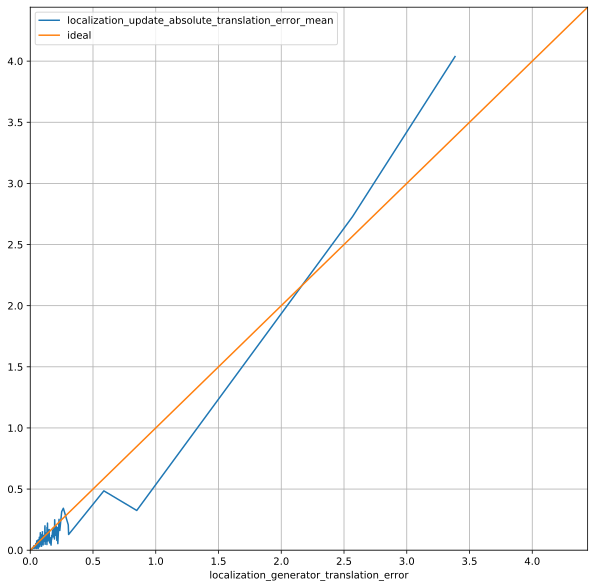

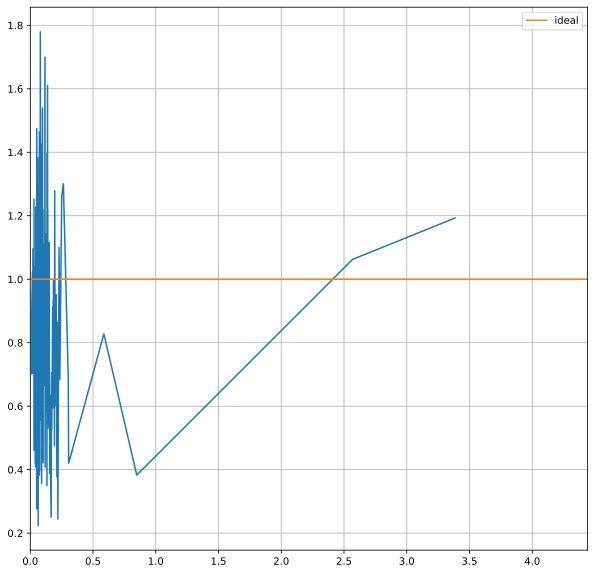

In [6]:
plot_generator_in_out('localization_generator_translation_error', 'localization_update_absolute_translation_error_mean')

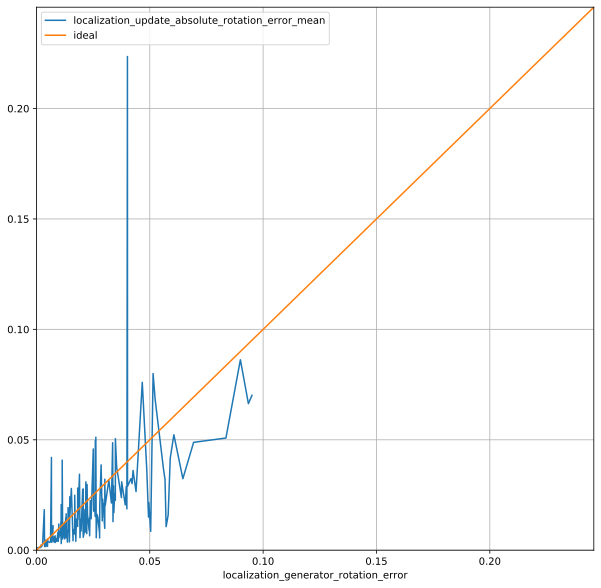

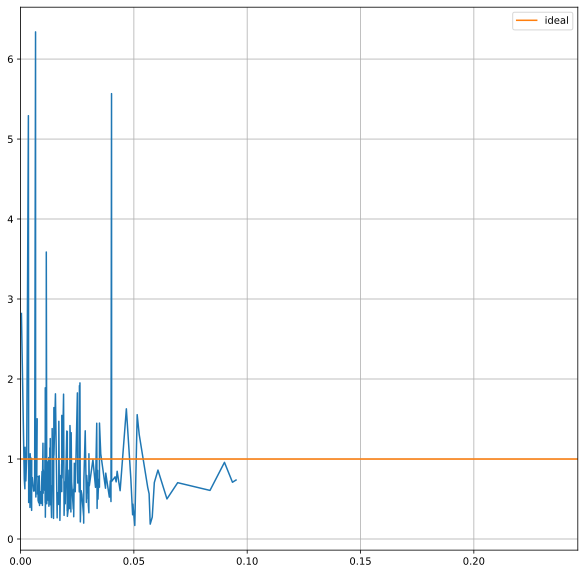

In [7]:
plot_generator_in_out('localization_generator_rotation_error', 'localization_update_absolute_rotation_error_mean')

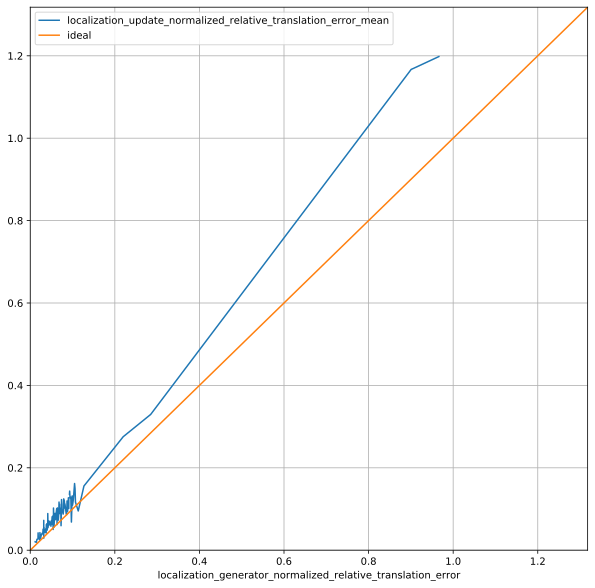

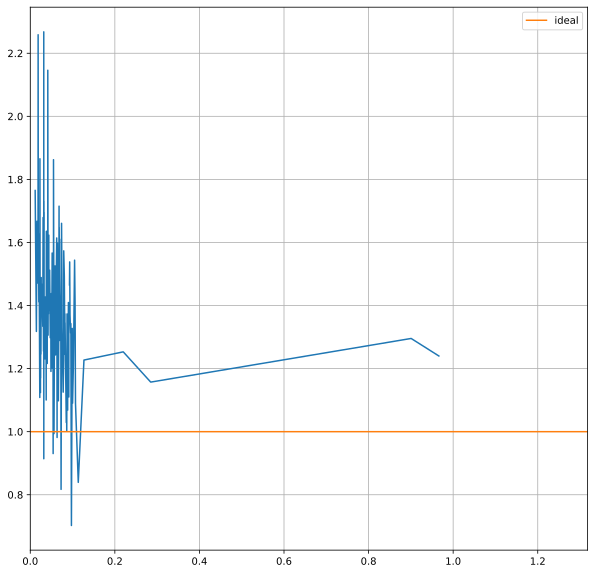

In [8]:
plot_generator_in_out('localization_generator_normalized_relative_translation_error', 'localization_update_normalized_relative_translation_error_mean')

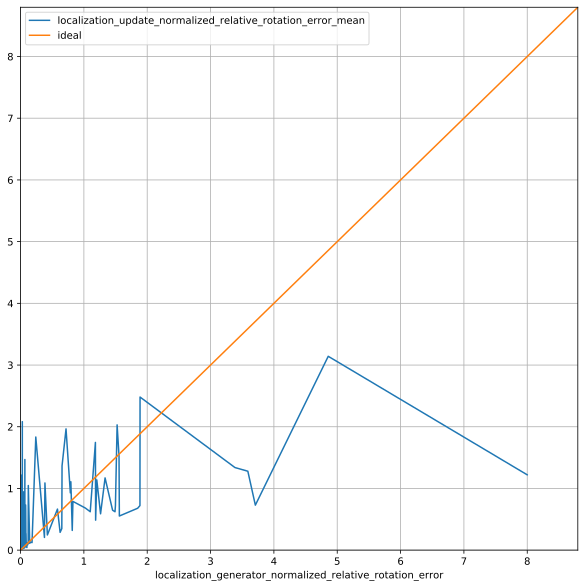

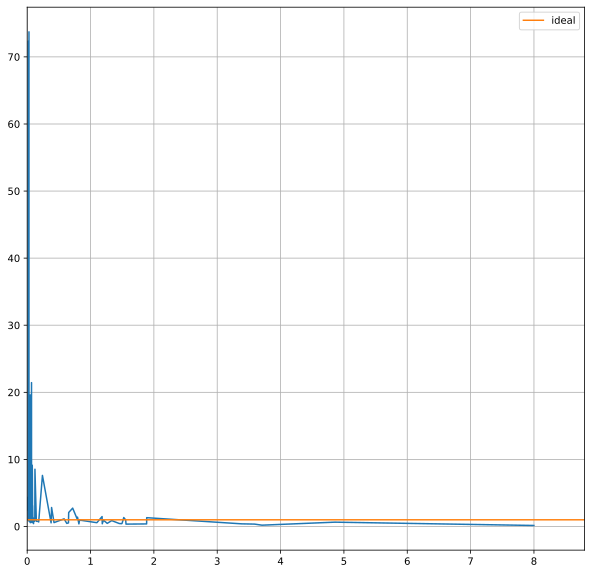

In [9]:
plot_generator_in_out('localization_generator_normalized_relative_rotation_error', 'localization_update_normalized_relative_rotation_error_mean')

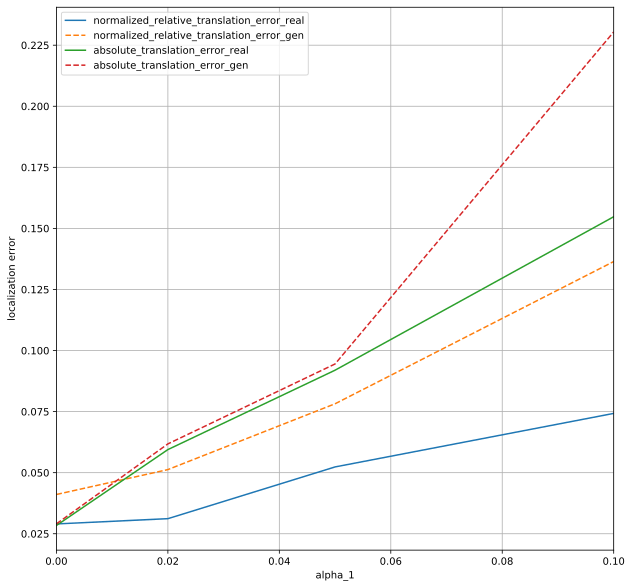

In [10]:
df_real.groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', label='normalized_relative_translation_error_real', grid=True)
df_gen.groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', label='normalized_relative_translation_error_gen', grid=True, linestyle='--')

df_real.groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', label='absolute_translation_error_real', grid=True)
df_gen.groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', label='absolute_translation_error_gen', grid=True, linestyle='--')

plt.legend()
plt.ylabel('localization error')
plt.show()